In [29]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Input, Concatenate
from tensorflow.keras.models import Model
from tensorflow.keras.utils import to_categorical
import matplotlib.pyplot as plt

In [16]:
df = pd.read_csv('station_day.csv')
df['Date'] = pd.to_datetime(df['Date'])

# Create date-based features
df['DayOfYear'] = df['Date'].dt.dayofyear
df['Month'] = df['Date'].dt.month
df['Year'] = df['Date'].dt.year



In [17]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 108035 entries, 0 to 108034
Data columns (total 19 columns):
 #   Column      Non-Null Count   Dtype         
---  ------      --------------   -----         
 0   StationId   108035 non-null  object        
 1   Date        108035 non-null  datetime64[ns]
 2   PM2.5       86410 non-null   float64       
 3   PM10        65329 non-null   float64       
 4   NO          90929 non-null   float64       
 5   NO2         91488 non-null   float64       
 6   NOx         92535 non-null   float64       
 7   NH3         59930 non-null   float64       
 8   CO          95037 non-null   float64       
 9   SO2         82831 non-null   float64       
 10  O3          82467 non-null   float64       
 11  Benzene     76580 non-null   float64       
 12  Toluene     69333 non-null   float64       
 13  Xylene      22898 non-null   float64       
 14  AQI         87025 non-null   float64       
 15  AQI_Bucket  87025 non-null   object        
 16  Da

In [18]:
# Correct syntax to drop columns
df = df.drop(columns=['PM10', 'NH3', 'Toluene', 'Xylene', 'AQI', 'AQI_Bucket'], axis=1)


In [19]:
# List of columns to fill NaN values
columns_to_fill = ['PM2.5', 'NO', 'NO2', 'NOx', 'CO', 'SO2', 'O3', 'Benzene']

# Fill NaN values for the specified columns without affecting the Date column
df[columns_to_fill] = df[columns_to_fill].fillna(df[columns_to_fill].mean())

# Ensure the Date column remains intact
print(df.head())  # Check if Date column is still present


  StationId       Date  PM2.5    NO    NO2    NOx    CO    SO2      O3  \
0     AP001 2017-11-24  71.36  1.75  20.65  12.40  0.10  10.76  109.26   
1     AP001 2017-11-25  81.40  1.44  20.50  12.08  0.12  15.24  127.09   
2     AP001 2017-11-26  78.32  1.26  26.00  14.85  0.14  26.96  117.44   
3     AP001 2017-11-27  88.76  6.60  30.85  21.77  0.11  33.59  111.81   
4     AP001 2017-11-28  64.18  2.56  28.07  17.01  0.09  19.00  138.18   

   Benzene  DayOfYear  Month  Year  
0     0.17        328     11  2017  
1     0.20        329     11  2017  
2     0.22        330     11  2017  
3     0.29        331     11  2017  
4     0.17        332     11  2017  


In [22]:
features = ['PM2.5', 'NO', 'NO2', 'NOx', 'CO', 'SO2', 'O3', 'Benzene']
scaler_features = MinMaxScaler()
df[features] = scaler_features.fit_transform(df[features])


In [23]:
scaler_date = MinMaxScaler()
df[['DayOfYear', 'Month', 'Year']] = scaler_date.fit_transform(df[['DayOfYear', 'Month', 'Year']])


In [25]:
station_ids = df['StationId'].unique()
station_id_to_index = {station: index for index, station in enumerate(station_ids)}
df['StationIdIndex'] = df['StationId'].map(station_id_to_index)
num_stations = len(station_ids)

In [26]:
def create_sequences(data, station_data, seq_length):
    X, y, X_station = [], [], []
    for i in range(len(data) - seq_length):
        X.append(data[i:(i + seq_length), :])
        y.append(data[i + seq_length, :len(features)])
        X_station.append(station_data[i + seq_length])
    return np.array(X), np.array(y), np.array(X_station)


In [27]:
seq_length = 30  # Use 30 days of data to predict the next day
X, y, X_station = create_sequences(df[features + ['DayOfYear', 'Month', 'Year']].values,
                                   df['StationIdIndex'].values,
                                   seq_length)

In [30]:
X_station = to_categorical(X_station, num_classes=num_stations)

In [31]:
X_train, X_test, y_train, y_test, X_station_train, X_station_test = train_test_split(
    X, y, X_station, test_size=0.2, random_state=42)

In [32]:
input_seq = Input(shape=(seq_length, X.shape[2]))
input_station = Input(shape=(num_stations,))

lstm_out = LSTM(64, activation='relu', return_sequences=True)(input_seq)
lstm_out = LSTM(32, activation='relu')(lstm_out)

concat = Concatenate()([lstm_out, input_station])
dense = Dense(32, activation='relu')(concat)
output = Dense(len(features))(dense)

model = Model(inputs=[input_seq, input_station], outputs=output)
model.compile(optimizer='adam', loss='mse')


In [33]:
history = model.fit(
    [X_train, X_station_train], y_train,
    epochs=100,
    batch_size=32,
    validation_split=0.1,
    verbose=1
)

Epoch 1/100
2431/2431 ━━━━━━━━━━━━━━━━━━━━ 71s 28ms/step - loss: 0.0029 - val_loss: 0.0014
Epoch 2/100
2431/2431 ━━━━━━━━━━━━━━━━━━━━ 80s 27ms/step - loss: 0.0013 - val_loss: 0.0013
Epoch 3/100
2431/2431 ━━━━━━━━━━━━━━━━━━━━ 81s 26ms/step - loss: 0.0012 - val_loss: 0.0012
Epoch 4/100
2431/2431 ━━━━━━━━━━━━━━━━━━━━ 83s 27ms/step - loss: 0.0012 - val_loss: 0.0011
Epoch 5/100
2431/2431 ━━━━━━━━━━━━━━━━━━━━ 83s 27ms/step - loss: 0.0011 - val_loss: 0.0011
Epoch 6/100
2431/2431 ━━━━━━━━━━━━━━━━━━━━ 82s 27ms/step - loss: 0.0011 - val_loss: 0.0011
Epoch 7/100
2431/2431 ━━━━━━━━━━━━━━━━━━━━ 82s 27ms/step - loss: 0.0010 - val_loss: 0.0010
Epoch 8/100
2431/2431 ━━━━━━━━━━━━━━━━━━━━ 82s 27ms/step - loss: 0.0011 - val_loss: 0.0010
Epoch 9/100
2431/2431 ━━━━━━━━━━━━━━━━━━━━ 65s 27ms/step - loss: 9.8883e-04 - val_loss: 0.0010
Epoch 10/100
2431/2431 ━━━━━━━━━━━━━━━━━━━━ 65s 27ms/step - loss: 9.7255e-04 - val_loss: 0.0010
Epoch 11/100
2431/2431 ━━━━━━━━━━━━━━━━━━━━ 83s 27ms/step - loss: 9.6257e-04 - va

In [34]:
def predict_future(model, last_sequence, future_date, station_id):
    # Prepare the input sequence
    input_seq = last_sequence.copy()

    # Update the date features for the future date
    future_day = future_date.dayofyear
    future_month = future_date.month
    future_year = future_date.year

    # Scale the future date features
    scaled_future_date = scaler_date.transform([[future_day, future_month, future_year]])[0]

    # Update the last day in the sequence with the future date
    input_seq[-1, -3:] = scaled_future_date

    # Prepare the station ID input
    station_index = station_id_to_index[station_id]
    station_one_hot = to_categorical([station_index], num_classes=num_stations)

    # Make the prediction
    prediction = model.predict([input_seq.reshape(1, seq_length, -1), station_one_hot])

    # Inverse transform the prediction
    return scaler_features.inverse_transform(prediction)[0]

In [35]:
last_sequence = df[features + ['DayOfYear', 'Month', 'Year']].values[-seq_length:]

In [36]:
future_date = pd.Timestamp('2025-10-05')
station_id = 'AP001'


In [37]:
future_prediction = predict_future(model, last_sequence, future_date, station_id)

# Create a DataFrame with the prediction
result_df = pd.DataFrame([future_prediction], columns=features, index=[future_date])
print(f"Predicted values for {future_date.date()} at Station ID {station_id}:")
print(result_df)

/usr/local/lib/python3.10/dist-packages/sklearn/base.py:465: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 372ms/step
Predicted values for 2025-10-05 at Station ID AP001:
                PM2.5        NO        NO2        NOx        CO      SO2  \
2025-10-05  28.529638 -1.833702  27.676949  22.522051  0.838839  4.26026   

                   O3   Benzene  
2025-10-05  23.823233  0.722482  


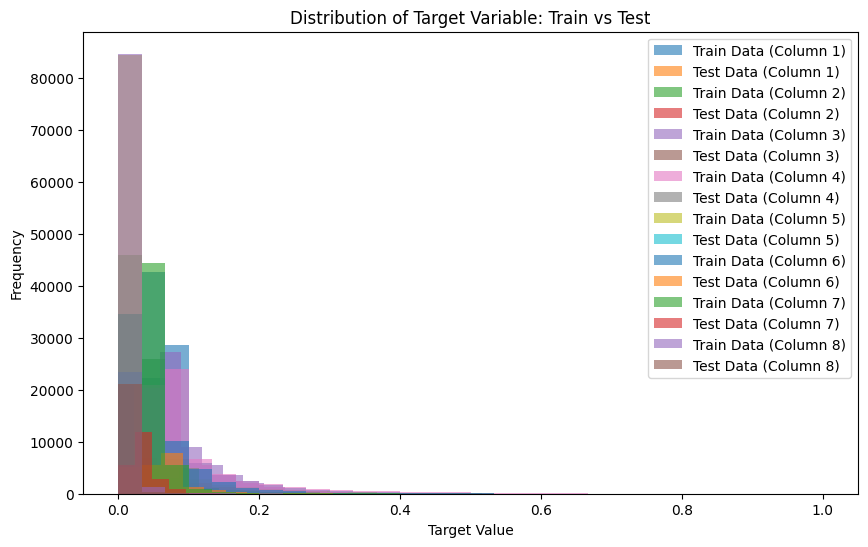

In [43]:
import matplotlib.pyplot as plt

# Visualize the distribution of the target variable in train and test sets
def visualize_train_test_distribution(y_train, y_test):
    plt.figure(figsize=(10, 6))

    # Check if y_train and y_test are multi-dimensional
    if y_train.ndim > 1:
        # If multi-dimensional, iterate over columns and plot histograms
        for i in range(y_train.shape[1]):
            plt.hist(y_train[:, i], bins=30, alpha=0.6, label=f'Train Data (Column {i+1})')
            plt.hist(y_test[:, i], bins=30, alpha=0.6, label=f'Test Data (Column {i+1})')
    else:
        # If not multi-dimensional, plot histograms as before
        plt.hist(y_train, bins=30, alpha=0.6, color='blue', label='Train Data')
        plt.hist(y_test, bins=30, alpha=0.6, color='orange', label='Test Data')

    # Add labels and title
    plt.title('Distribution of Target Variable: Train vs Test')
    plt.xlabel('Target Value')
    plt.ylabel('Frequency')
    plt.legend()

    # Show plot
    plt.show()

# Example usage
visualize_train_test_distribution(y_train, y_test)



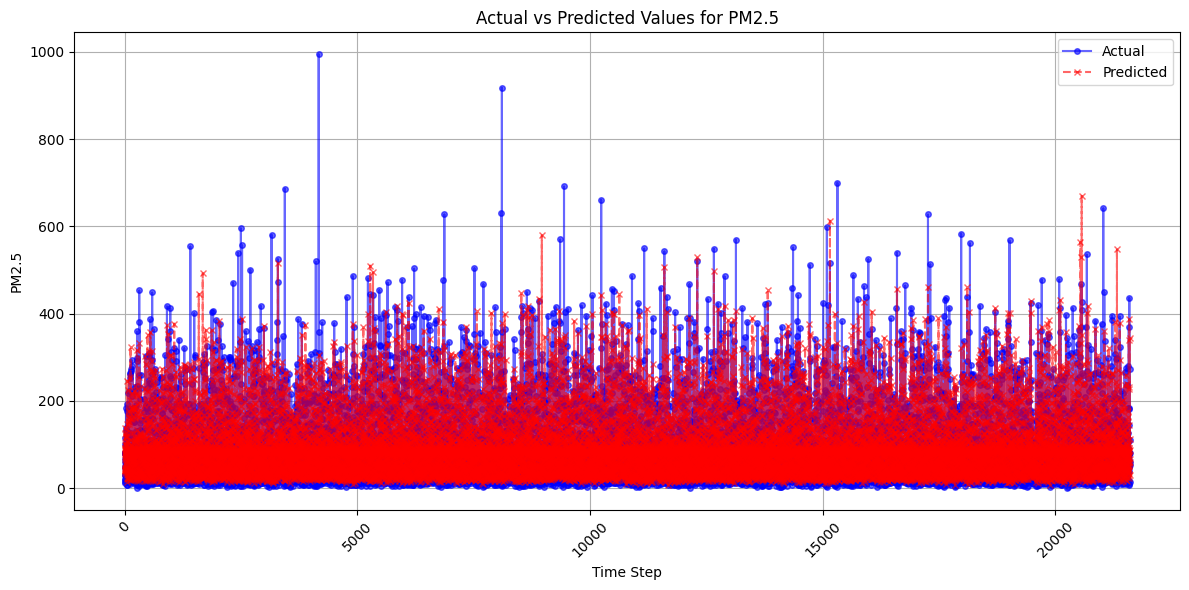

In [46]:
import matplotlib.pyplot as plt

def plot_feature_comparison(y_test, y_pred, feature, feature_name='PM2.5'):
    plt.figure(figsize=(12, 6))

    # Plot actual values
    plt.plot(y_test[:, feature], label='Actual', color='blue', linestyle='-', marker='o', markersize=4, alpha=0.6)

    # Plot predicted values
    plt.plot(y_pred[:, feature], label='Predicted', color='red', linestyle='--', marker='x', markersize=4, alpha=0.6)

    # Add titles and labels
    plt.title(f'Actual vs Predicted Values for {feature_name}')
    plt.xlabel('Time Step')
    plt.ylabel(feature_name)
    plt.xticks(rotation=45)
    plt.grid()
    plt.legend()

    # Show plot
    plt.tight_layout()
    plt.show()

# Example usage for PM2.5 (assuming it's the first feature in the list)
plot_feature_comparison(y_test_inverse, y_pred_inverse, feature=0, feature_name='PM2.5')


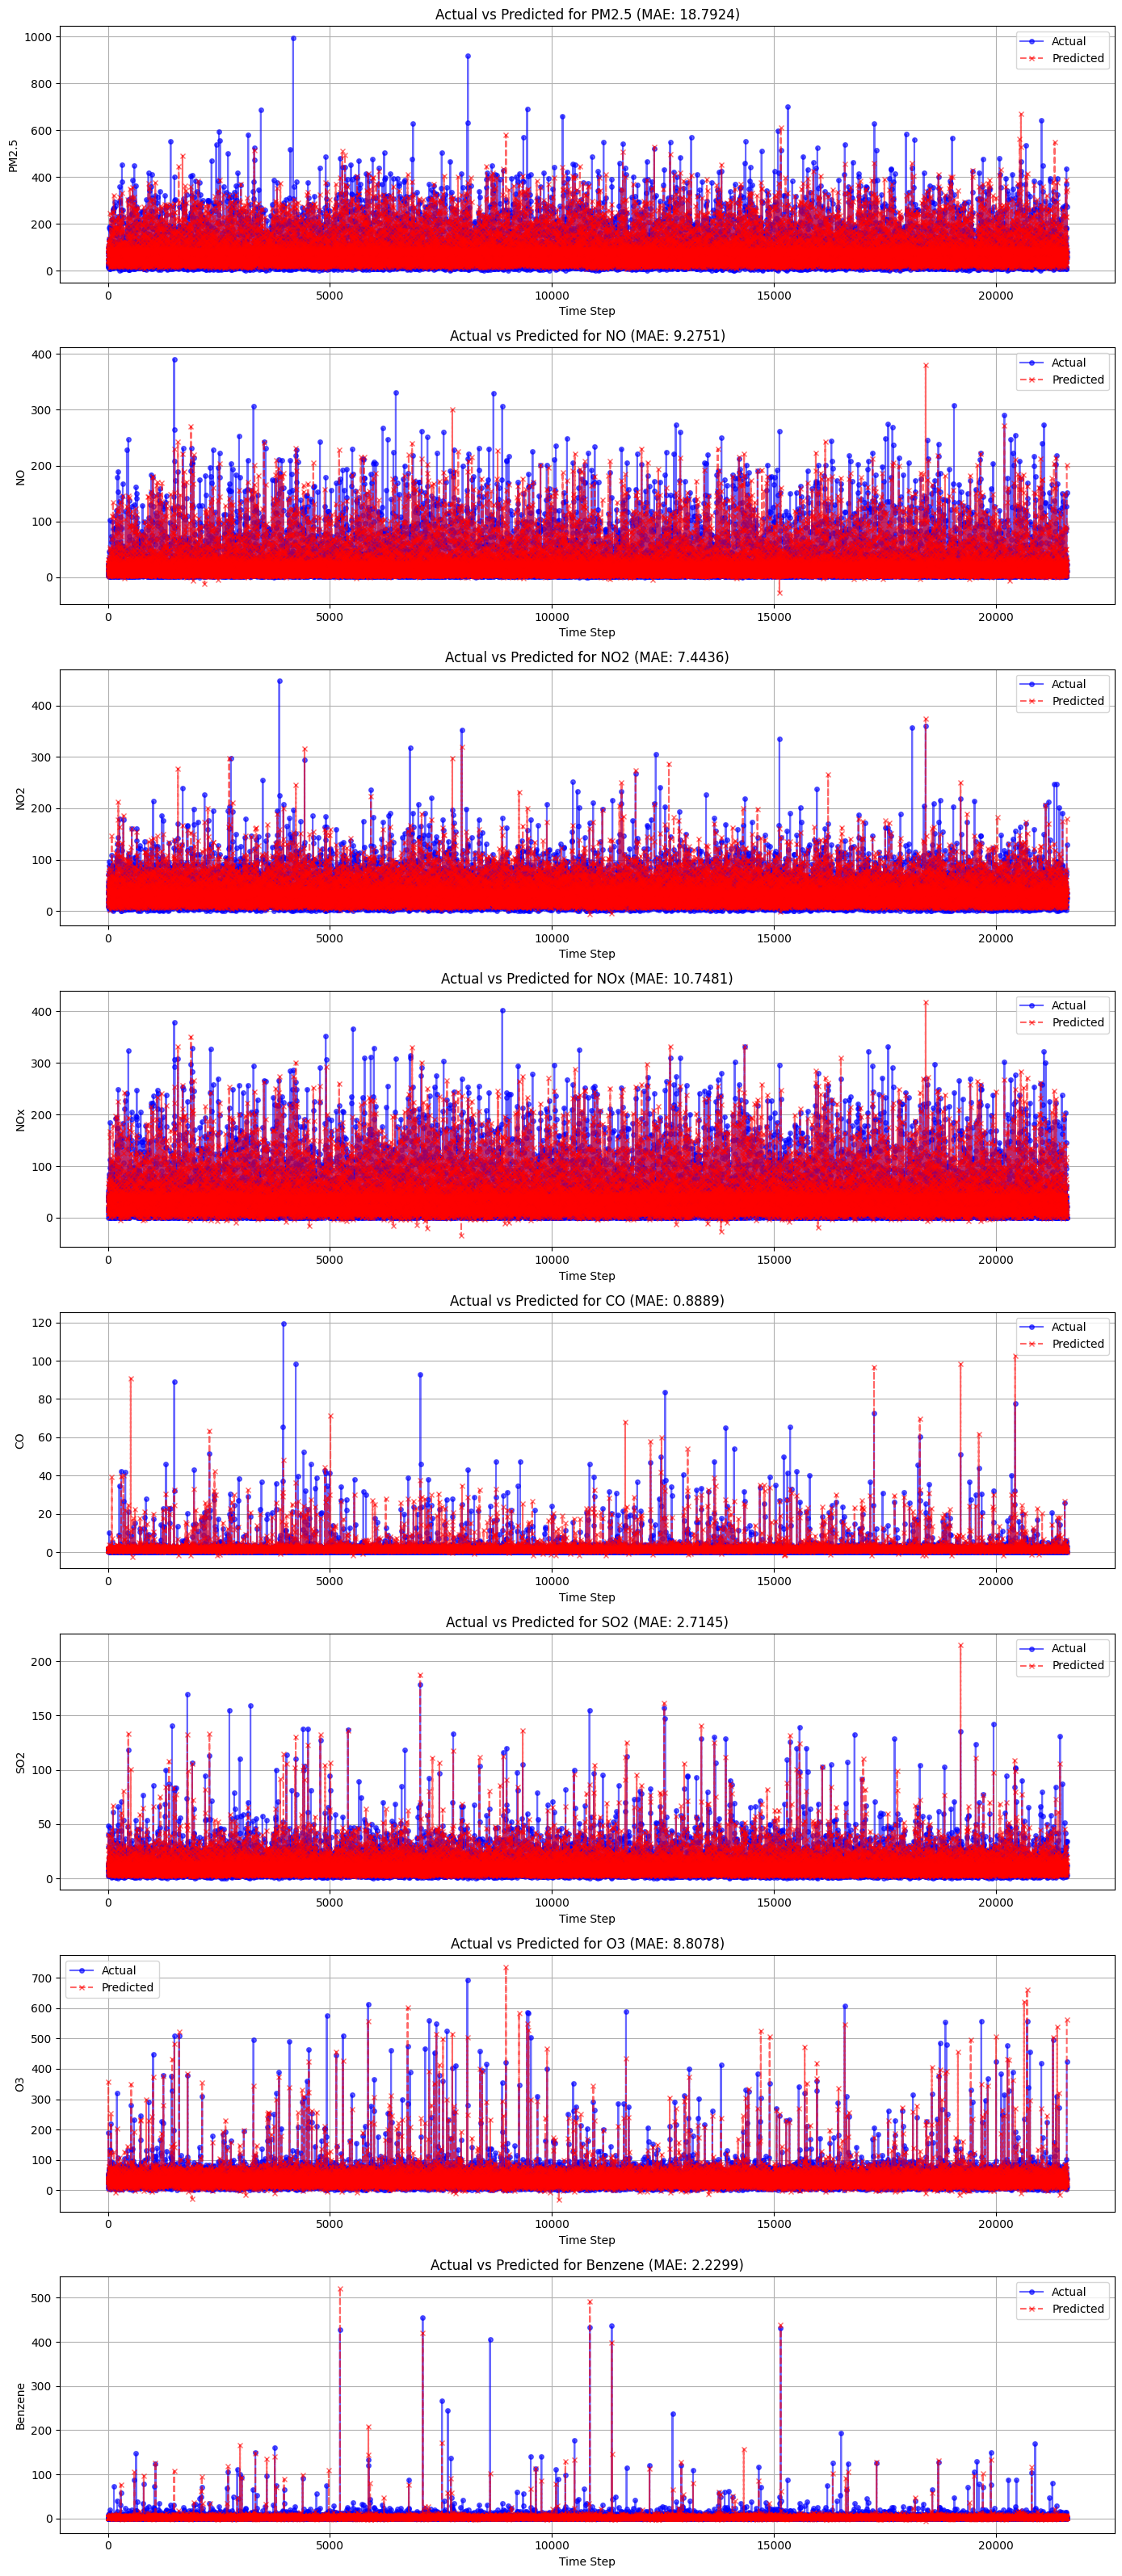

Mean Absolute Error for PM2.5: 18.7924
Mean Absolute Error for NO: 9.2751
Mean Absolute Error for NO2: 7.4436
Mean Absolute Error for NOx: 10.7481
Mean Absolute Error for CO: 0.8889
Mean Absolute Error for SO2: 2.7145
Mean Absolute Error for O3: 8.8078
Mean Absolute Error for Benzene: 2.2299


In [49]:
import matplotlib.pyplot as plt
from sklearn.metrics import mean_absolute_error

def plot_all_features_with_mae(y_test, y_pred, features):
    n_features = len(features)
    mae_values = []

    plt.figure(figsize=(14, 4 * n_features))  # Adjust the height based on number of features

    # Loop through each feature
    for i, feature in enumerate(features):
        # Calculate MAE for the feature
        mae = mean_absolute_error(y_test[:, i], y_pred[:, i])
        mae_values.append(mae)

        # Create a subplot for each feature
        plt.subplot(n_features, 1, i + 1)
        plt.plot(y_test[:, i], label='Actual', color='blue', linestyle='-', marker='o', markersize=4, alpha=0.6)
        plt.plot(y_pred[:, i], label='Predicted', color='red', linestyle='--', marker='x', markersize=4, alpha=0.6)

        # Add titles and labels
        plt.title(f'Actual vs Predicted for {feature} (MAE: {mae:.4f})')
        plt.xlabel('Time Step')
        plt.ylabel(feature)
        plt.grid()
        plt.legend()

    plt.tight_layout()
    plt.show()

    # Print the MAE for each feature
    for feature, mae in zip(features, mae_values):
        print(f'Mean Absolute Error for {feature}: {mae:.4f}')

# Example usage
plot_all_features_with_mae(y_test_inverse, y_pred_inverse, features)


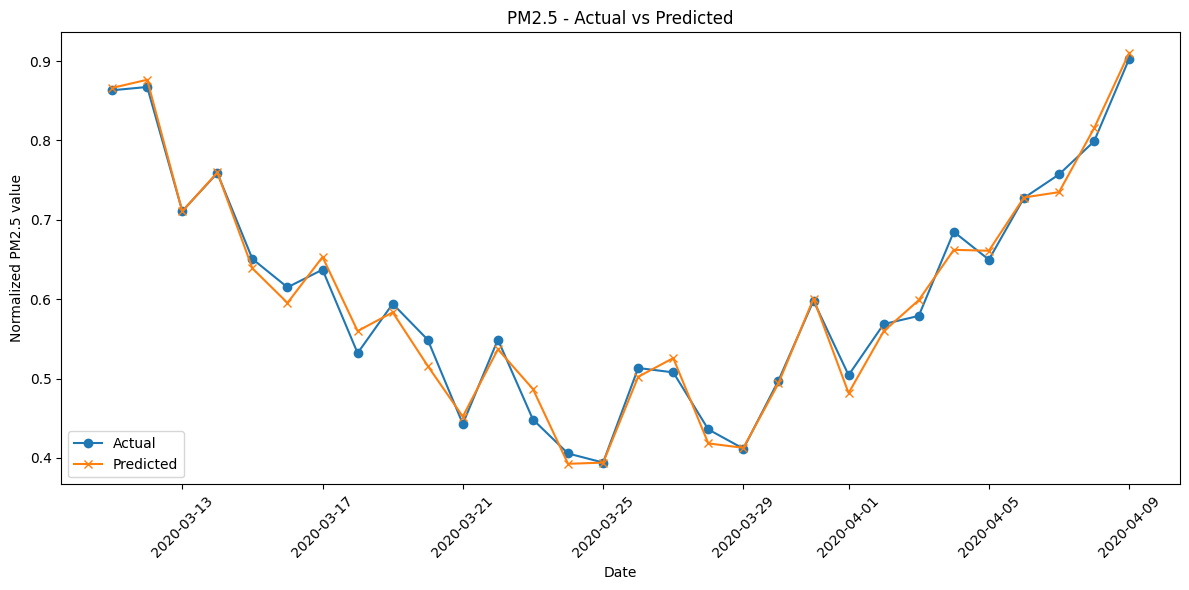

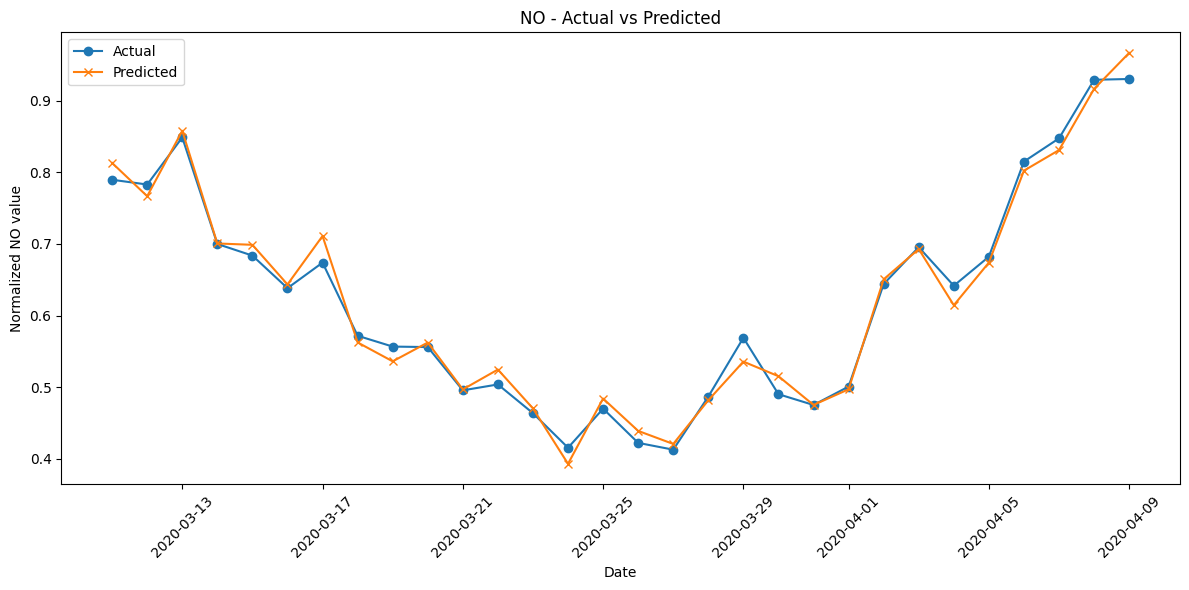

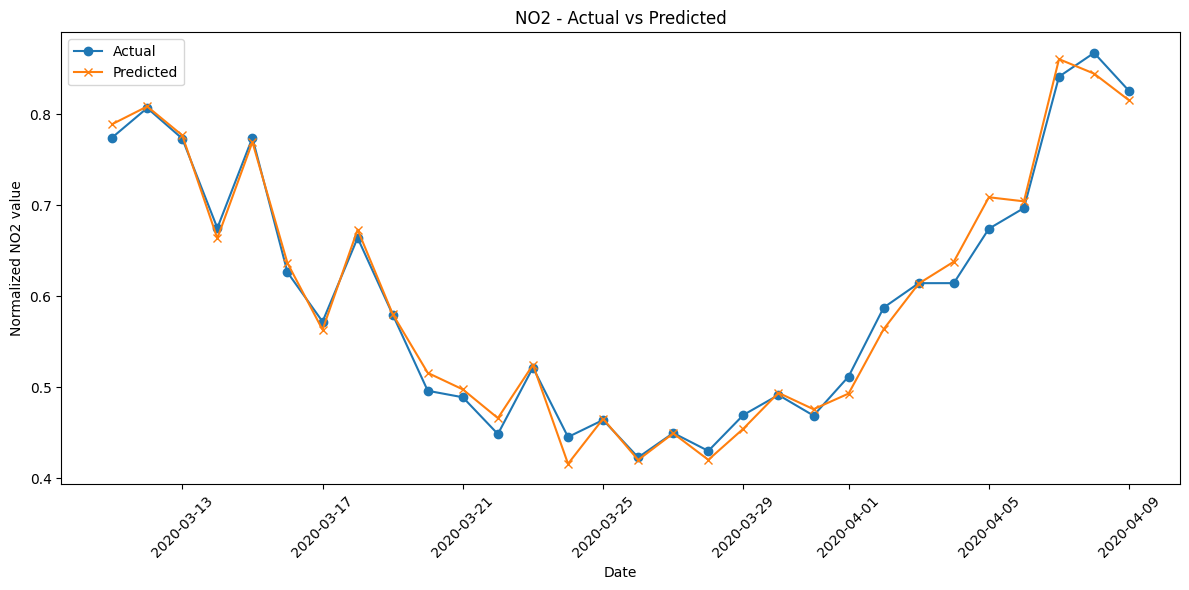

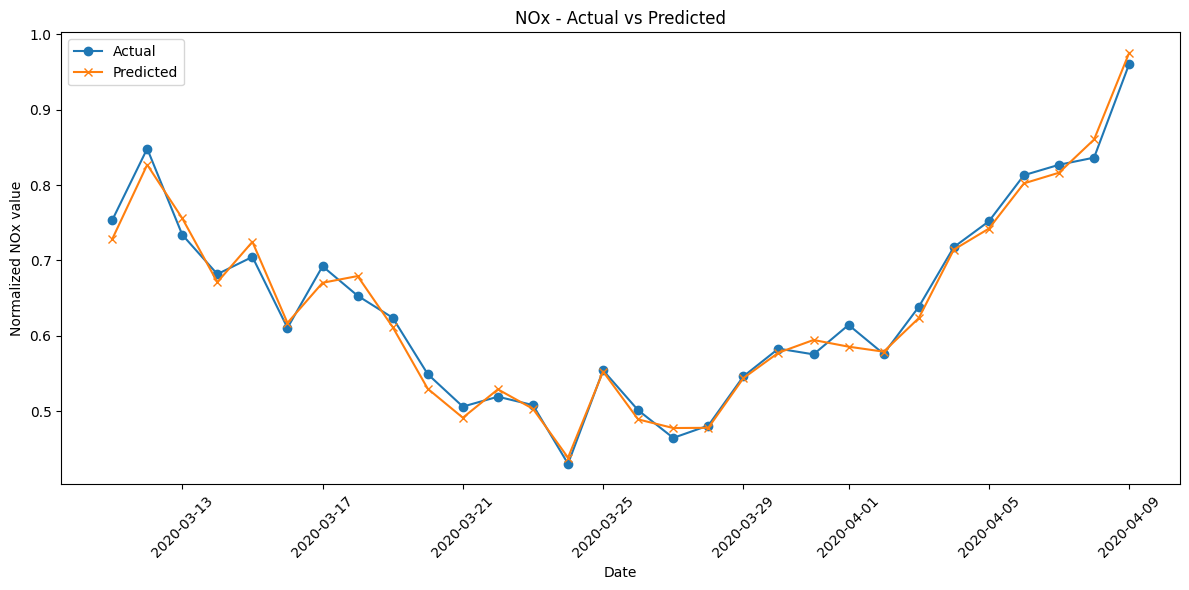

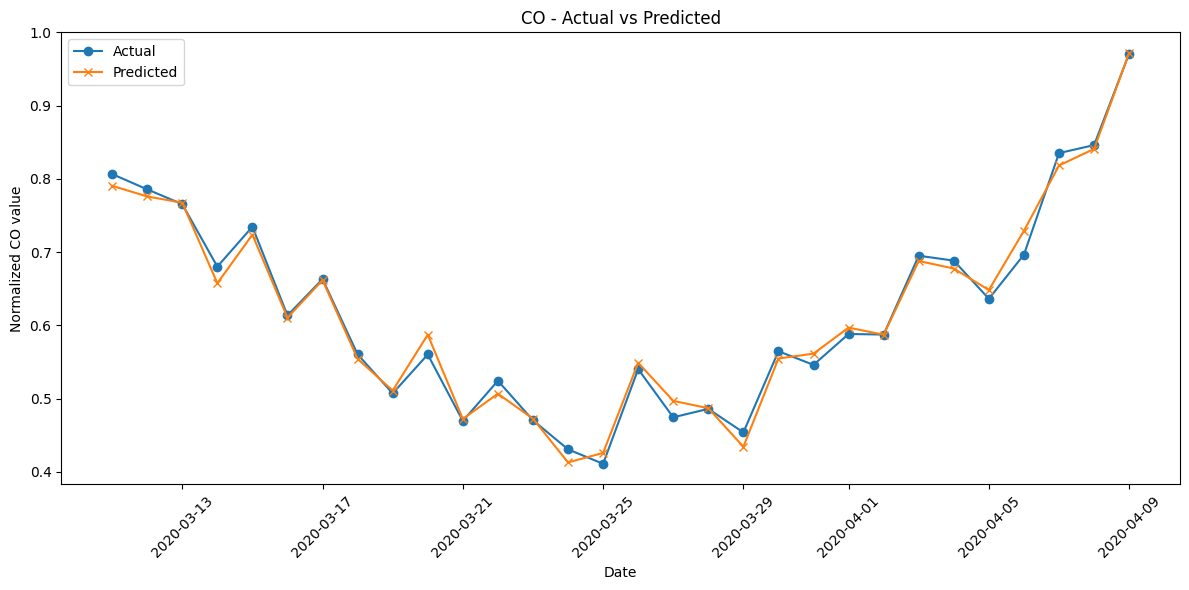

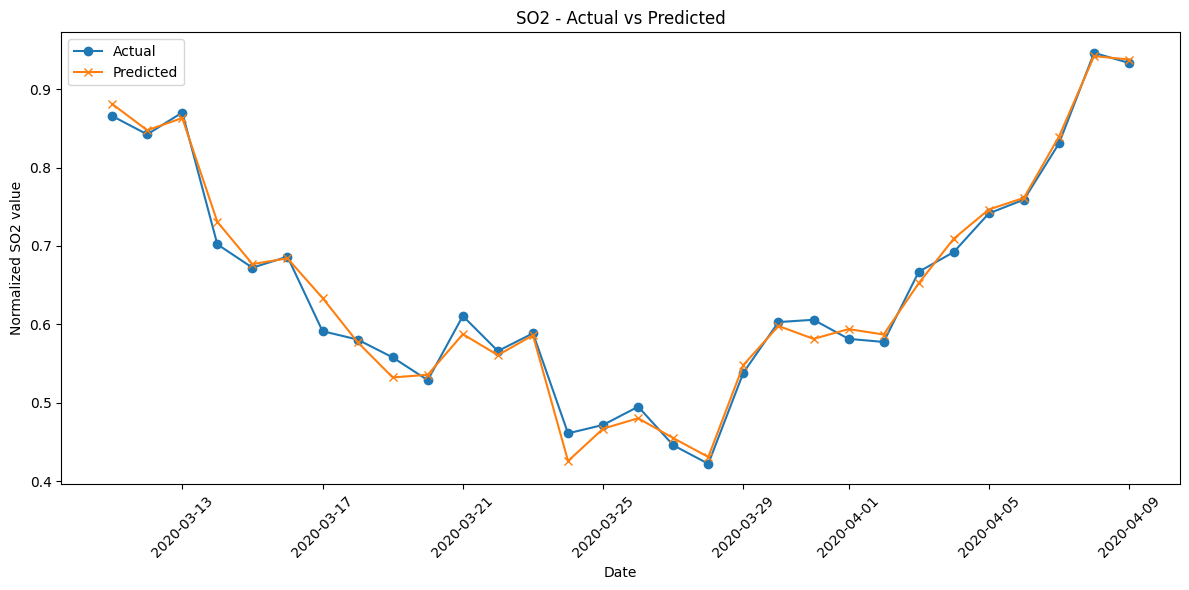

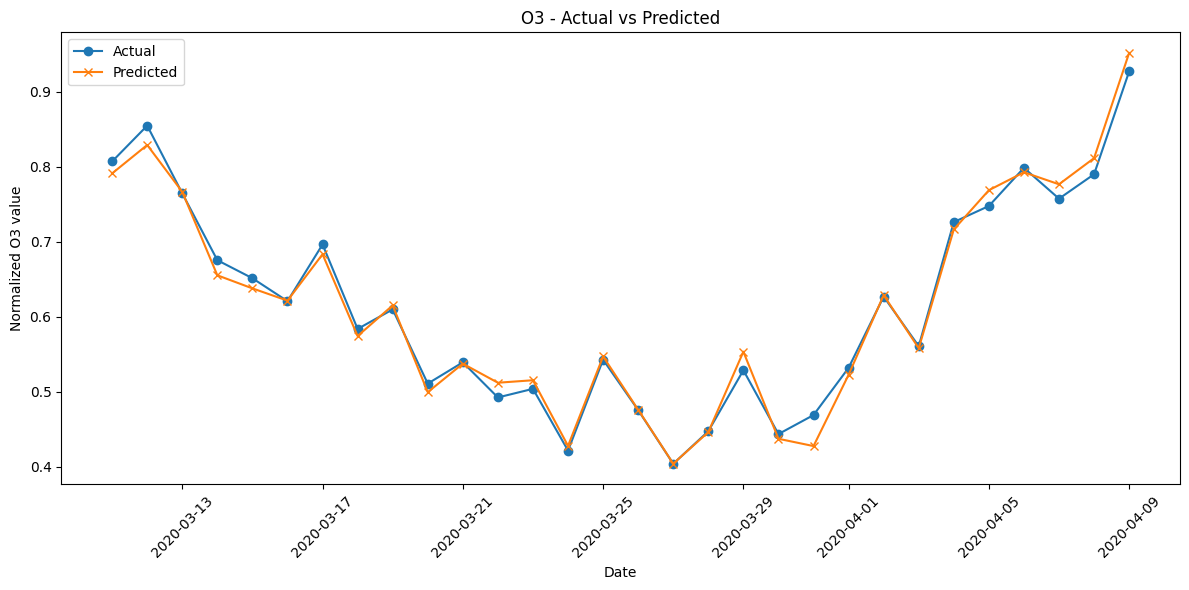

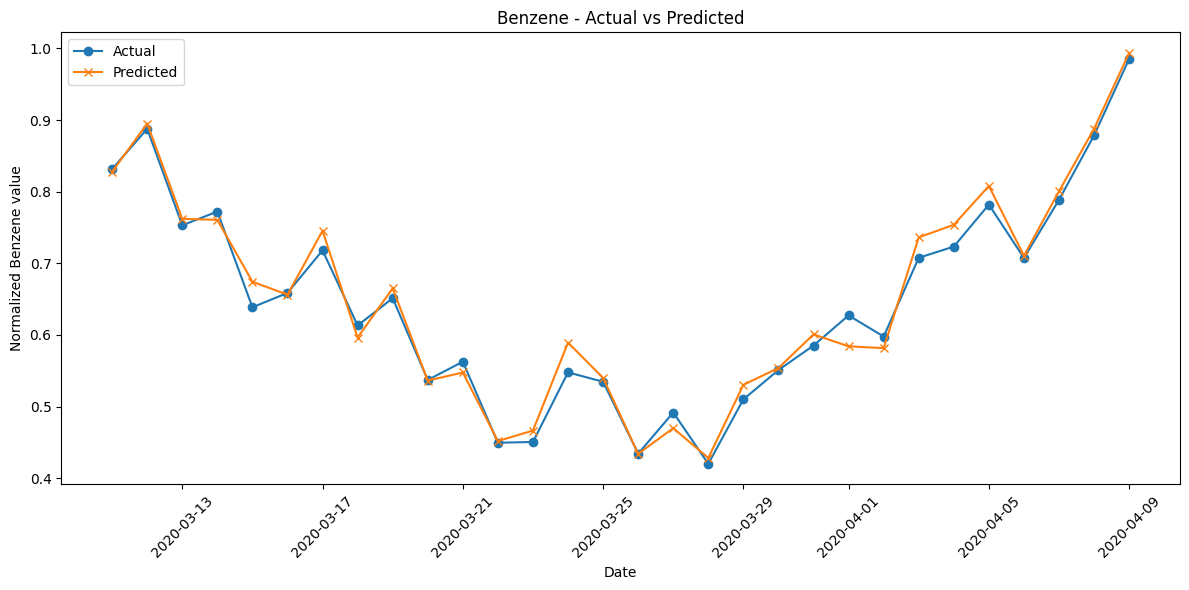

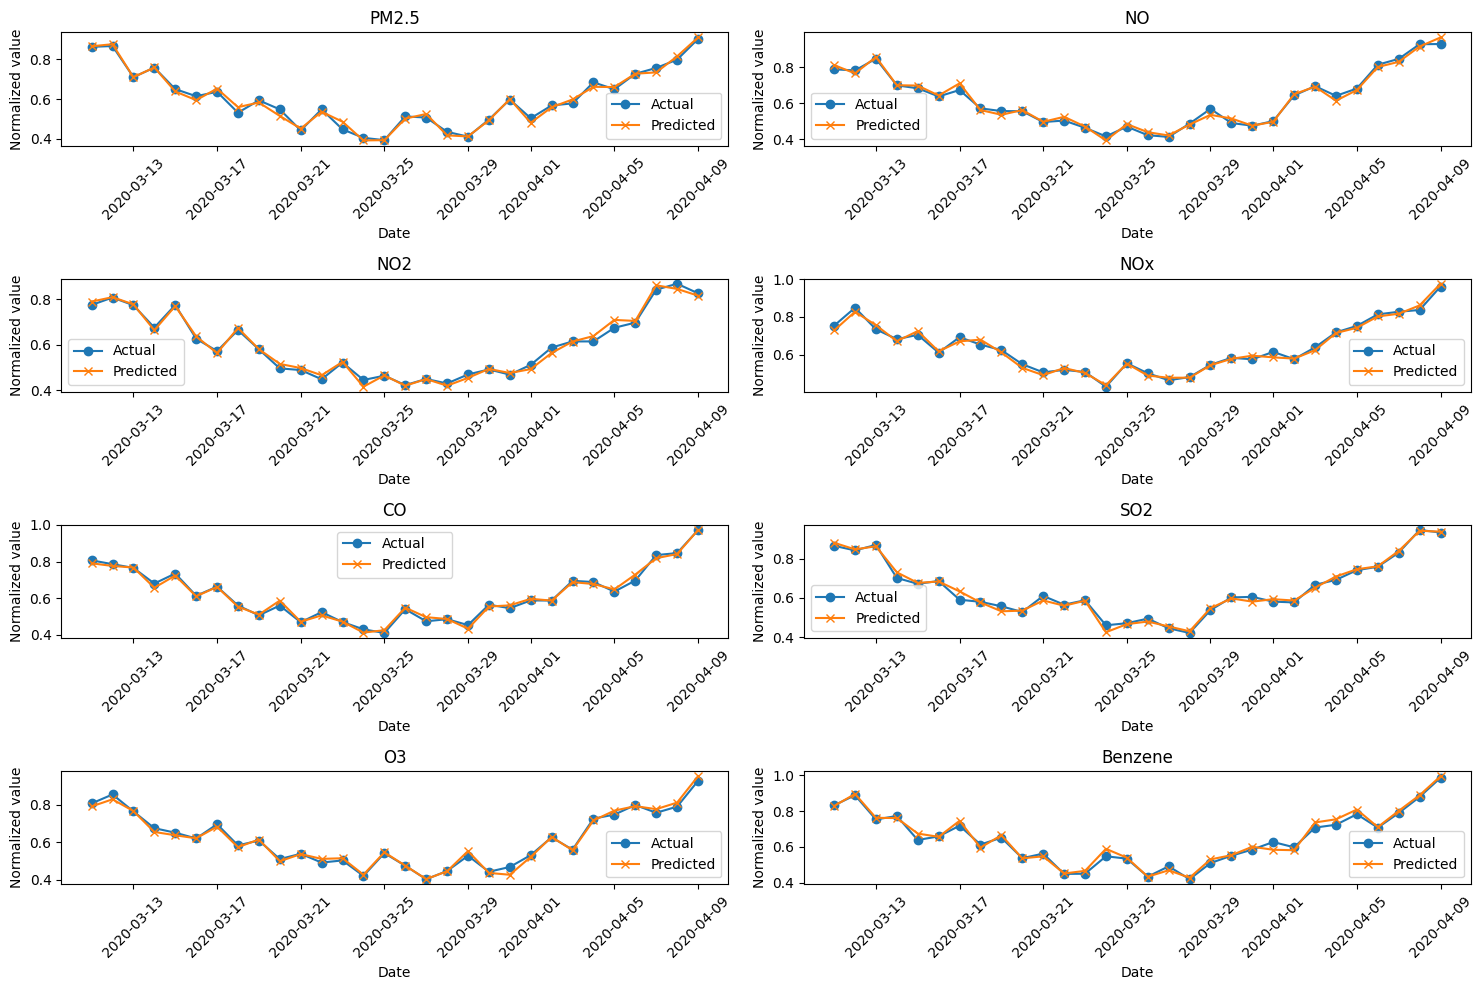

Mean Absolute Error for PM2.5: 0.0130
Mean Absolute Error for NO: 0.0141
Mean Absolute Error for NO2: 0.0114
Mean Absolute Error for NOx: 0.0133
Mean Absolute Error for CO: 0.0110
Mean Absolute Error for SO2: 0.0121
Mean Absolute Error for O3: 0.0117
Mean Absolute Error for Benzene: 0.0152


In [40]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler

# Generate sample data
np.random.seed(42)
date_range = pd.date_range(start='2020-01-01', periods=100, freq='D')
features = ['PM2.5', 'NO', 'NO2', 'NOx', 'CO', 'SO2', 'O3', 'Benzene']

# Create sample actual data
actual_data = np.random.rand(100, len(features))
# Add some trend and seasonality to make it more realistic
for i in range(len(features)):
    actual_data[:, i] += np.linspace(0, 5, 100)  # trend
    actual_data[:, i] += 2 * np.sin(np.linspace(0, 4*np.pi, 100))  # seasonality

# Create sample predictions (actual + some noise)
predictions = actual_data + np.random.normal(0, 0.1, actual_data.shape)

# Normalize the data
scaler = MinMaxScaler()
actual_data_scaled = scaler.fit_transform(actual_data)
predictions_scaled = scaler.transform(predictions)

# Number of days to plot
num_days = 30

# Plot predictions vs actual for each feature
for i, feature in enumerate(features):
    plt.figure(figsize=(12, 6))
    plt.plot(date_range[-num_days:], actual_data_scaled[-num_days:, i], label='Actual', marker='o')
    plt.plot(date_range[-num_days:], predictions_scaled[-num_days:, i], label='Predicted', marker='x')
    plt.title(f'{feature} - Actual vs Predicted')
    plt.xlabel('Date')
    plt.ylabel(f'Normalized {feature} value')
    plt.legend()
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

# Plot all features in a single graph
plt.figure(figsize=(15, 10))
for i, feature in enumerate(features):
    plt.subplot(4, 2, i+1)
    plt.plot(date_range[-num_days:], actual_data_scaled[-num_days:, i], label='Actual', marker='o')
    plt.plot(date_range[-num_days:], predictions_scaled[-num_days:, i], label='Predicted', marker='x')
    plt.title(feature)
    plt.xlabel('Date')
    plt.ylabel('Normalized value')
    plt.legend()
    plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# Calculate and print Mean Absolute Error for each feature
mae = np.mean(np.abs(actual_data_scaled[-num_days:] - predictions_scaled[-num_days:]), axis=0)
for feature, error in zip(features, mae):
    print(f"Mean Absolute Error for {feature}: {error:.4f}")